# 27 Class American Sign Language Recognition

Silia Georgaki

# Dataset

Various datasets exist related to American Sign Language. In this
particular example, a [27 Classes
Dataset](https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset)
was used. Essential for data preprocessing is an understanding of the
data’s format. Therefore, by reading the
[paper](https://arxiv.org/ftp/arxiv/papers/2203/2203.03859.pdf) created
by the dataset’s creators, the following information is extracted:

-   The data comes from 173 volunteers.
-   Signs are shaped using the right hand.
-   It includes the numbers: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 (static
    gestures).
-   It includes the letters: A, B, C, D, E (static gestures).
-   It includes expressions: Hello, Yes, No, Good, Bye, Good morning,
    Pardon, Project, Little bit, Please, What’s up (dynamic gestures).
-   It contains the class NULL: 314 images without any gesture and with
    a different background.
-   The images were captured using an RGB camera with a 3024 x 3024
    pixel frame size.
-   Image size: 128 x 128.
-   The images are normalized.
-   130 images were taken from each person, 5 from each class.
-   Total number of images: 22,801.
-   The processed images were stored in a numpy Tensor ‘X’ with 4
    dimensions (number of images, image height, image width, RGB
    channels).
-   A numpy Tensor ‘Y’ was created, containing the labels of the images
    and having 2 dimensions (number of images, 1). That is, each image
    corresponds to one label.

# Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Data Handling

## Load Data

In [2]:
# Load data
x_data = np.load('x.npy') # Images
y_data = np.load('y.npy') # Labels

## Shapes of data

In [3]:
print("Tensor with images has shape: ", x_data.shape)
print("Tensor with labels has shape: ", y_data.shape)
print("An image has shape: ", x_data.shape[1::])

Tensor with images has shape:  (22801, 128, 128, 3)
Tensor with labels has shape:  (22801, 1)
An image has shape:  (128, 128, 3)

# See the classes and Display images

In the following cell, the unique labels that appear are identified.
This process will return the sorted unique elements of the label tensor.
As a result, the variable classes will contain the label of each class
sorted.

In [4]:
# Classes
classes = np.unique(y_data)
print("Classes are: ", classes)

Classes are:  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'NULL' 'a' 'b' 'bye' 'c' 'd' 'e'
 'good' 'good morning' 'hello' 'little bit' 'no' 'pardon' 'please'
 'project' 'whats up' 'yes']

## Display a single image

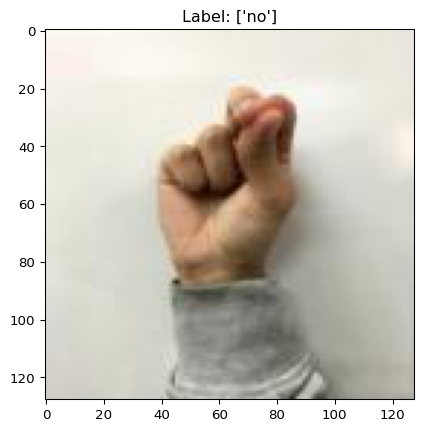

In [5]:
# Plot only the image at index 1726 with it's label
image = x_data[1726]
label = y_data[1726]

plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

## Display an image from each Class

As there are 27 classes in this specific dataset, a representation with
3 rows and 9 columns was chosen. For each class, the first image
corresponding to that class is displayed, along with the label
indicating which class the image represents.

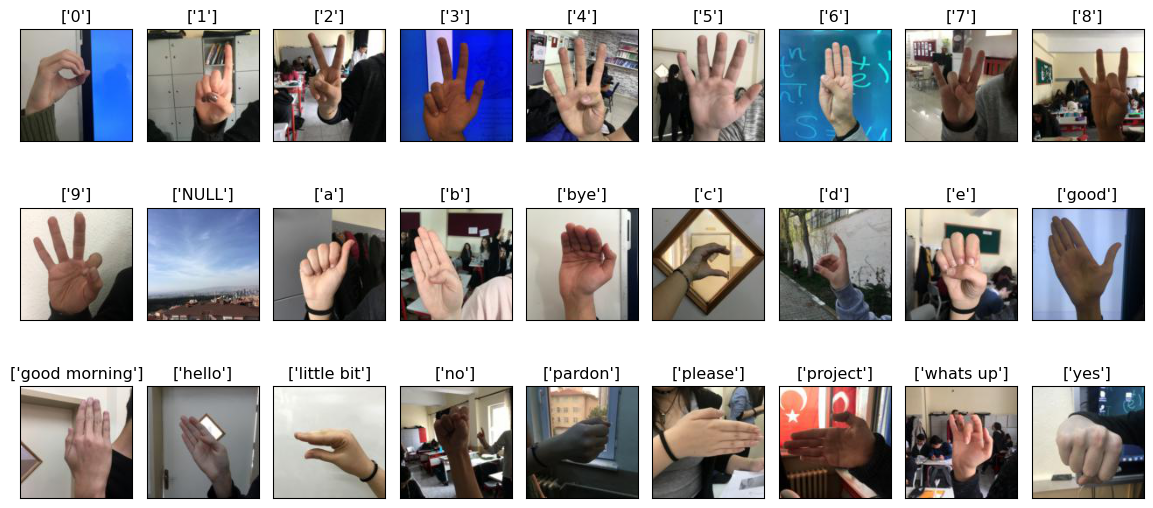

In [6]:
# Create subplots with 3 rows and 9 columns
fig, axs = plt.subplots(3, 9, figsize=(12, 6), subplot_kw={'xticks': [], 'yticks': []}) # xticks and yticks as a list means the axis will not be displayed.

# Loop through each label and plot one image of the class with it's label
for i, label in enumerate(classes):
    # Get the index of the first instance of this label
    index = np.where(y_data == label)[0][0]
    
    # Get the corresponding image and label
    image = x_data[index]
    label = y_data[index]
    
    # Plot the image with it's label in the corresponding subplot
    axs[i // 9, i % 9].imshow(image) # i // 9 (floor division) gives the row index, i % 9 (modulus) gives the column index 
    axs[i // 9, i % 9].set_title(f"{label}")

# Show the plot
plt.tight_layout()
plt.show()

# One-Hot Encoding

Next, each class will be assigned an integer, creating a “label
dictionary.” This dictionary is then used in the next cell to achieve
One-Hot-Encoding. Using the aforementioned dictionary, the mapping of
classes is performed. Specifically, the labels are converted into
integer representations, and using these, the integer labels are
transformed into One-Hot-Encoded vectors. Through this technique,
categorical values are converted into binary vectors where each category
is represented by the value 0 or 1. Additionally, the length of the
binary vector is equal to the number of unique categories of the encoded
variable. As neural networks expect numerical input, this process is
deemed necessary for the training process.

In [7]:
# Define label dictionary
label_dict = {label: i for i, label in enumerate(classes)}
print("The label dictionary is: ", label_dict)

# Map the class names to integers using the label_dict dictionary
y_int = np.array([label_dict[label] for label in y_data.flatten()])

# Convert the integer labels to one-hot encoded vectors
y_cat = to_categorical(y_int, num_classes=len(label_dict)).astype(int)

The label dictionary is:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'NULL': 10, 'a': 11, 'b': 12, 'bye': 13, 'c': 14, 'd': 15, 'e': 16, 'good': 17, 'good morning': 18, 'hello': 19, 'little bit': 20, 'no': 21, 'pardon': 22, 'please': 23, 'project': 24, 'whats up': 25, 'yes': 26}

# Class Distribution

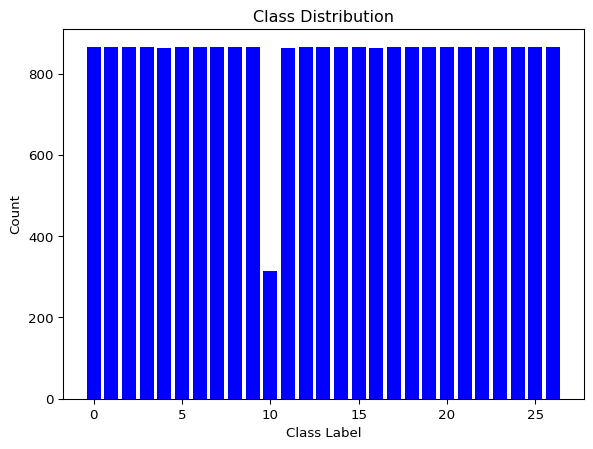

In [8]:
# Convert one-hot encoded labels back to integer labels
y_int_labels = np.argmax(y_cat, axis = 1)

# Count the occurrences of each class
class_counts = np.bincount(y_int_labels)
 
# Get the unique class labels
unique_labels = np.unique(y_int_labels)

# Plot the class distribution
plt.bar(unique_labels, class_counts, color = 'blue')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Data Augmentation

As already known, the dataset includes images without gestures and
images taken in different backgrounds. This generalizes the results,
reduces the likelihood of overfitting, and simultaneously represents
reality. For the same purpose, data augmentation is employed. However,
another reason why this technique may be useful is because the NULL
class does not contain an equal number of images compared to the other
classes; thus, this technique helps balance the dataset. Another
advantage is that, as the images contain various information (such as
different backgrounds), the model will be forced to learn additional
features that may lead to better results. Specifically, the following
augmentations are applied to the images:

-   Random rotation up to 0.1 radians
-   Random zoom up to 0.1
-   Horizontal flip

We expect each one to benefit the training process as each person has
his personal way of signing. Additionally, there are both right handed
as well as left handed signers.

In [9]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
])

# Display original and augmented image

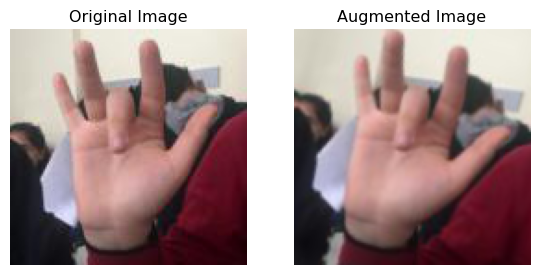

In [10]:
# Original sample image
original_image = x_data[1000]

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Augment the image using the data augmentation pipeline
augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training = True)
augmented_image = augmented_image[0].numpy()

# Display the augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image')
plt.axis('off')
plt.show()

# Training

In the following cell, the data is split into training and test sets,
where the test set comprises 30% of the total data. In each execution,
the same sequence of random numbers will be generated using the
random_state.

## Split dataset

In [11]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_cat, test_size = 0.3, random_state = 42)

print("x_train shape is:", x_train.shape) # Train set images
print("y_train shape is:", y_train.shape) # Train set labels
print("x_test shape is:", x_test.shape) # Test set images
print("y_test shape is:", y_test.shape) # Test set labels

x_train shape is: (15960, 128, 128, 3)
y_train shape is: (15960, 27)
x_test shape is: (6841, 128, 128, 3)
y_test shape is: (6841, 27)

## Build the model

In the following cell, the architecture of the neural network is
implemented. Specifically, a Convolutional Neural Network (CNN) is
created, consisting of:

-   Data augmentation, as defined earlier.
-   A convolutional layer with 64 filters, a kernel size of 3x3, and
    ReLU activation function. The 64 filters indicate that a map of 64
    features will be extracted. The kernel size is essentially the
    sliding window during convolution, with a size of 3x3, sliding
    during the convolution process. The ReLU activation function adds
    non-linearity to the network. The input data is the images, so the
    input_shape is set to the size of each image. Two additional
    convolutional layers with 128 and 256 filters are used to extract
    maps of 128 and 256 features, respectively.
-   Three MaxPooling layers for subsampling. These layers reduce the
    dimension of the features by taking the maximum in 2x2 regions. This
    is used to reduce parameters and extract the most important
    features.
-   A flatten() layer, which converts the three-dimensional
    representation of features into a flat one to be used in fully
    connected layers.
-   Three fully connected layers. Two of them consist of 256 and 512
    neurons, respectively. This serves as a transformation of input
    features into a space of reduced dimensions while taking as input
    the neurons from the previous layer. Additionally, ReLU activation
    functions are used. Finally, a fully connected layer with neurons
    equal to the number of classes we want to predict is used. The
    softmax activation function is employed, which takes a vector of k
    real values and returns a vector with k values in the range 0-1,
    with the characteristic that the sum of these values equals 1. This
    allows the results to be interpreted as probabilities.

In [12]:
# Build the model
model = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(len(label_dict), activation = 'softmax')
])  

## Compile and Train the model

Additional features of the training include:

-   **Adam optimizer**: Adam is an optimization algorithm used to find
    the optimal parameters for minimizing the cost function. It is
    effective for training neural networks.
-   **Learning rate of 0.001**: The learning rate is a hyperparameter
    that controls the step size during optimization. A suitable learning
    rate can lead to faster convergence, but an inappropriate value may
    lead to divergence. In this case, a fixed learning rate of 0.001 is
    chosen for more stable training.
-   **Categorical crossentropy loss function**: This loss function is
    selected because there are multiple classes, and it describes the
    performance of the model in terms of categorical prediction.
-   **Accuracy as a metric**: Accuracy is used as a metric to measure
    the percentage of correct predictions.

Special actions during training include:

-   **Early stopping**: The training process stops early if there is no
    improvement in the model’s performance for 10 epochs. Additionally,
    the weights of the model are saved from the point where the best
    performance is achieved.
-   **Learning rate reduction**: If the model’s performance stops
    increasing for 5 epochs, the learning rate is reduced by a factor of
    0.1. This helps to fine-tune the training process and achieve better
    convergence.

In [13]:
# Compile the model
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor = 0.1, patience = 5)

# Train the model
history = model.fit(x_train, y_train, epochs = 200, validation_data = (x_test, y_test), callbacks = [early_stopping, reduce_lr], verbose = 0)

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)      

# Evaluate model

  1/214 [..............................] - ETA: 42s - loss: 0.1998 - accuracy: 0.9375  2/214 [..............................] - ETA: 44s - loss: 0.1575 - accuracy: 0.9531  3/214 [..............................] - ETA: 42s - loss: 0.2503 - accuracy: 0.9375  4/214 [..............................] - ETA: 43s - loss: 0.1927 - accuracy: 0.9531  5/214 [..............................] - ETA: 43s - loss: 0.2114 - accuracy: 0.9563  6/214 [..............................] - ETA: 42s - loss: 0.2767 - accuracy: 0.9323

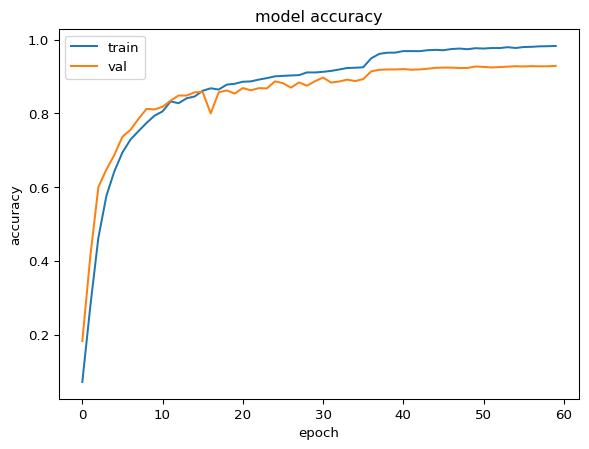

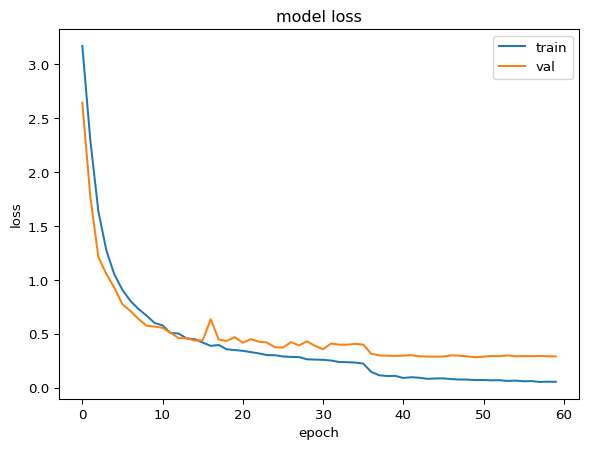

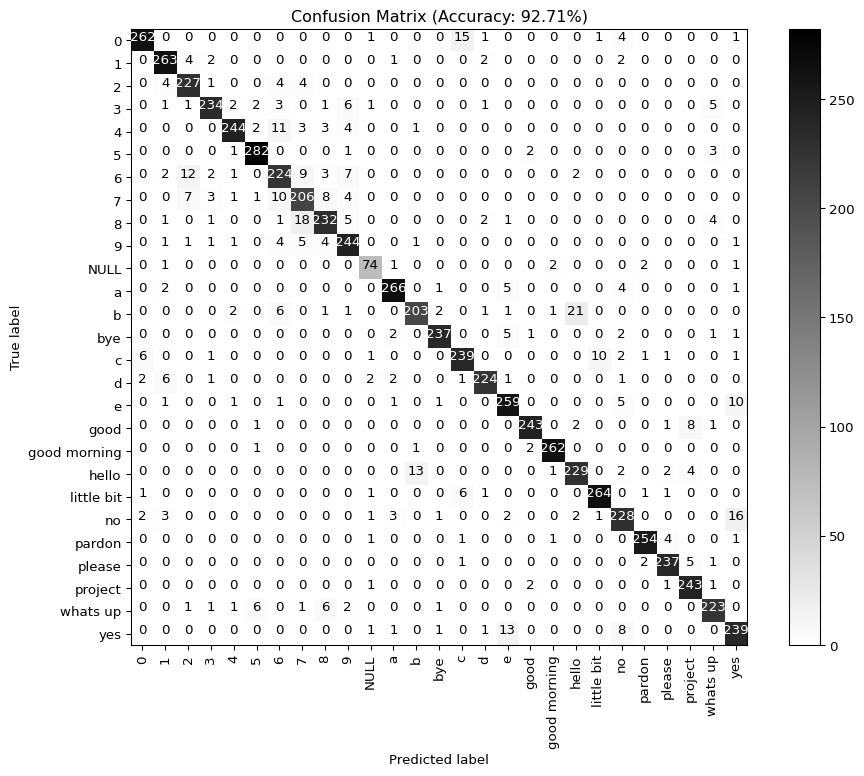

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

# Plot accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# Plot loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.show()

# Confusion Matrix
# Calculate predictions
y_pred = model.predict(x_test)

# Convert one-hot encoded predictions back to integer labels
y_pred_labels = np.argmax(y_pred, axis = 1)
y_true_labels = np.argmax(y_test, axis = 1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)

# Define the binary colormap
cmap = plt.cm.binary

# Create a figure with a larger size
plt.figure(figsize = (10, 8))

# Plot the confusion matrix
plt.imshow(confusion_mtx, interpolation = 'nearest', cmap = cmap)
plt.title(f'Confusion Matrix (Accuracy: {accuracy * 100:.2f}%)')

# Add labels for clarity
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 90)
plt.yticks(tick_marks, classes)

# Add text annotations for each cell
thresh = confusion_mtx.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion_mtx[i, j], 'd'), horizontalalignment = "center", color = "white" if confusion_mtx[i, j] > thresh else "black")

plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

From the resuls above, it seems that the training process was
successful.

## Evaluation Metrics

The use of “weighted” averaging in precision, recall, and F1 score
calculations is often employed when dealing with imbalanced datasets.
The “weighted” averaging takes into account the class imbalance by
assigning different weights to different classes based on their
prevalence in the dataset. This ensures that the metric calculation
gives appropriate importance to each class, regardless of its size.
Specifically:

-   Weighted Accuracy:

    -   Accuracy is the ratio of correct predictions to the total number
        of predictions. In imbalanced datasets, accuracy might be
        misleading since a model could achieve high accuracy by simply
        predicting the majority class. Weighted accuracy considers the
        class imbalance and calculates the average accuracy, giving more
        weight to classes with more instances.

-   Weighted Precision:

    -   Precision is the ratio of true positive predictions to the total
        predicted positives. In imbalanced datasets, where some classes
        have fewer instances, precision might be high for the majority
        class but low for minority classes. Weighted precision considers
        the imbalance and calculates the average precision, giving more
        weight to classes with more instances.

-   Weighted Recall:

    -   Recall (sensitivity) is the ratio of true positive predictions
        to the total actual positives. Similar to weighted precision,
        weighted recall considers the imbalance and calculates the
        average recall, giving more weight to classes with more
        instances.

-   Weighted F1 Score:

    -   F1 score is the harmonic mean of precision and recall. It
        provides a balance between precision and recall. Weighted F1
        score considers the imbalance and calculates the average F1
        score, giving more weight to classes with more instances.

In [15]:
# Calculate precision, recall, and F1 score for a multiclass problem
precision = precision_score(y_true_labels, y_pred_labels, average = 'weighted')
recall = recall_score(y_true_labels, y_pred_labels, average = 'weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average = 'weighted')

# Print the scores
print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')

Accuracy: 0.92706
Precision: 0.92761
Recall: 0.92706
F1 Score: 0.92709

Overall, the training process was successful and the model built is
suitable for the American Sign Language Recognition problem.